# Preprocess data of COVID-19 for the analysis

In [4]:
import os
import sys
import datetime
import numpy as np
import pandas as pd
import urllib.request
from github import Github
from getpass import getpass

from IPython.display import clear_output, display

## Login to GitHub

In [5]:
access_token = getpass()

 ········································


In [6]:
# Login
g = Github(access_token)

# Get the COVID-19 repository of CSSEGISandData
repo = g.get_repo('CSSEGISandData/COVID-19')

## Load data from the GitHub repository of CSSEGISandData

In [7]:
# The root directory of the COVID datasets in the CSSEGISandData's repository
_root = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/'

In [8]:
# Get the names of the directories, which contain the daily reports of the pandemic
# There are two different directories:
#   - One contains data for the US
#   - The other one contains data for the rest of the world
world_repo = repo.get_contents('./csse_covid_19_data/csse_covid_19_daily_reports/')
us_repo = repo.get_contents('./csse_covid_19_data/csse_covid_19_daily_reports_us/')

### Gather all URLs where the daily datasets are stored in raw format

In [9]:
daily_world_raw = []
daily_us_raw = []

for d in world_repo:
    _name = d.path
    if '.csv' in _name:
        daily_world_raw.append(_root + _name)

for d in us_repo:
    _name = d.path
    if '.csv' in _name:
        daily_us_raw.append(_root + _name)

### Check a some datatables to inspect their structure

In [10]:
url_test = daily_world_raw[5]
with urllib.request.urlopen(url_test) as url:
    data_test = pd.read_csv(url, sep=',', comment='#', header=0)

In [11]:
data_test.head()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,Hubei,Mainland China,1/27/20 23:59,1423,76.0,45.0
1,Guangdong,Mainland China,1/27/20 23:59,151,NaN,4.0
2,Zhejiang,Mainland China,1/27/20 23:59,128,NaN,1.0
3,Henan,Mainland China,1/27/20 23:59,128,1.0,NaN
4,Chongqing,Mainland China,1/27/20 23:59,110,NaN,NaN


In [12]:
data_test.tail()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
46,NaN,Cambodia,1/27/20 23:59,1,NaN,NaN
47,NaN,Sri Lanka,1/27/20 23:59,1,NaN,NaN
48,NaN,Ivory Coast,1/27/20 23:59,1,NaN,NaN
49,New South Wales,Australia,1/27/20 23:59,4,NaN,NaN
50,Victoria,Australia,1/27/20 23:59,1,NaN,NaN


In [13]:
url_test = daily_world_raw[-1]
with urllib.request.urlopen(url_test) as url:
    data_test = pd.read_csv(url, sep=',', comment='#', header=0)

In [14]:
data_test.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
0,NaN,NaN,NaN,Afghanistan,2020-09-02 04:28:25,33.93911,67.709953,38196,1406,29231,7559.0,Afghanistan,98.118746,3.681014
1,NaN,NaN,NaN,Albania,2020-09-02 04:28:25,41.15330,20.168300,9606,290,5441,3875.0,Albania,333.796650,3.018946
2,NaN,NaN,NaN,Algeria,2020-09-02 04:28:25,28.03390,1.659600,44833,1518,31493,11822.0,Algeria,102.239301,3.385899
3,NaN,NaN,NaN,Andorra,2020-09-02 04:28:25,42.50630,1.521800,1184,53,908,223.0,Andorra,1532.388533,4.476351
4,NaN,NaN,NaN,Angola,2020-09-02 04:28:25,-11.20270,17.873900,2729,109,1084,1536.0,Angola,8.303346,3.994137


In [15]:
data_test.tail()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
3949,NaN,NaN,NaN,West Bank and Gaza,2020-09-02 04:28:25,31.952200,35.233200,23281,159,15338,7784.0,West Bank and Gaza,456.363488,0.682960
3950,NaN,NaN,NaN,Western Sahara,2020-09-02 04:28:25,24.215500,-12.885800,10,1,8,1.0,Western Sahara,1.674116,10.000000
3951,NaN,NaN,NaN,Yemen,2020-09-02 04:28:25,15.552727,48.516388,1962,570,1160,232.0,Yemen,6.578160,29.051988
3952,NaN,NaN,NaN,Zambia,2020-09-02 04:28:25,-13.133897,27.849332,12381,290,11479,612.0,Zambia,67.346767,2.342299
3953,NaN,NaN,NaN,Zimbabwe,2020-09-02 04:28:25,-19.015438,29.154857,6559,203,5241,1115.0,Zimbabwe,44.129935,3.094984


The structure heavily changed since the first data release, and thus we need to manually bodge it together to get a usable dataset.

### Gather all daily dataset

In [43]:
data_tables_world = []
data_tables_us = []

for raw_url in daily_world_raw:
    with urllib.request.urlopen(raw_url) as url:
        sys.stdout.flush()
        sys.stdout.write('\rCurrent file (world): {}'.format(raw_url.split('/')[-1]))
        data_tables_world.append(pd.read_csv(url, sep=',', comment='#', header=0))
clear_output()
for raw_url in daily_us_raw:
    with urllib.request.urlopen(raw_url) as url:
        sys.stdout.flush()
        sys.stdout.write('\rCurrent file (US): {}'.format(raw_url.split('/')[-1]))
        data_tables_us.append(pd.read_csv(url, sep=',', comment='#', header=0))
clear_output()
print('FINISHED!')

FINISHED!


## Standardize data tables

During the (currently still active) period of the data release, numerous entries, labels and columns were changed for the sake of clarity and usablity. When it comes to the construction of time series, we have to standardize all tables first, only after that should we proceed with the aggregation. The standardization creates the opportunity to efficiently handle separate daily reports just as cross sections of the (now uniform) dataset. In this section the 

### 0. Standardize column names

Some column names were changed between the first and the last release of the daily reports. First we need to standardize column names for all data tables. The affected columns are the following:

| Old label               | New label         |
|:----------------------- |:----------------- |
| `Country/Region`        | `Country_Region`  |
| `Last Update`           | `Last_Update`     |
| `Lat`                   | `Latitude`        |
| `Long_`                 | `Longitude`       |
| `Province/State`        | `Province_State`  |

#### Global data

In [44]:
column_formats = set()
for df in data_tables_world:
    cols = df.columns
    for c in cols:
        column_formats.add(c)

In [45]:
column_formats

{'Active',
 'Admin2',
 'Case-Fatality_Ratio',
 'Combined_Key',
 'Confirmed',
 'Country/Region',
 'Country_Region',
 'Deaths',
 'FIPS',
 'Incidence_Rate',
 'Last Update',
 'Last_Update',
 'Lat',
 'Latitude',
 'Long_',
 'Longitude',
 'Province/State',
 'Province_State',
 'Recovered'}

In [46]:
column_dict_world = {
    'Country/Region' : 'Country_Region',
    'Last Update' : 'Last_Update',
    'Lat' : 'Latitude',
    'Long_' : 'Longitude',
    'Province/State' : 'Province_State'
}

column_dict_world_K = [k for k, _ in column_dict_world.items()]
column_dict_world_V = [v for _, v in column_dict_world.items()]

In [47]:
for i, df in enumerate(data_tables_world):
    # Column names of the current DataFrame
    cols = df.columns
    # Create a dictionary with the new column names, since
    # the pandas.DataFrame.rename method requires a  dictionary as
    # its attribute
    new_cols = {}
    for c in cols:
        if c in column_dict_world_K:
            new_cols[c] = column_dict_world[c]
        else:
            new_cols[c] = c
    
    data_tables_world[i] = df.rename(columns=new_cols)

#### US data

In [48]:
column_formats = set()
for df in data_tables_us:
    cols = df.columns
    for c in cols:
        column_formats.add(c)

In [49]:
column_formats

{'Active',
 'Confirmed',
 'Country_Region',
 'Deaths',
 'FIPS',
 'Hospitalization_Rate',
 'ISO3',
 'Incident_Rate',
 'Last_Update',
 'Lat',
 'Long_',
 'Mortality_Rate',
 'People_Hospitalized',
 'People_Tested',
 'Province_State',
 'Recovered',
 'Testing_Rate',
 'UID'}

In [50]:
column_dict_us = {
    'Lat' : 'Latitude',
    'Long_' : 'Longitude',
}

column_dict_us_K = [k for k, _ in column_dict_us.items()]
column_dict_us_V = [v for _, v in column_dict_us.items()]

In [51]:
for i, df in enumerate(data_tables_us):
    # Column names of the current DataFrame
    cols = df.columns
    # Create a dictionary with the new column names, since
    # the pandas.DataFrame.rename method requires a  dictionary as
    # its attribute
    new_cols = {}
    for c in cols:
        if c in column_dict_us_K:
            new_cols[c] = column_dict_us[c]
        else:
            new_cols[c] = c
    
    data_tables_us[i] = df.rename(columns=new_cols)

There are a lot of dispensable columns in the data tables, which are simply unnecessary for this analysis. To further standardize columns, we can trim down these columns from tables in the dataset.

In [52]:
# We keep these columns in the tables
column_names = ['Province_State', 'Country_Region', 'Last_Update', 'Confirmed', 'Recovered', 'Deaths']

In [53]:
for i, df in enumerate(data_tables_world):
    data_tables_world[i] = df[column_names]

In [54]:
for i, df in enumerate(data_tables_us):
    data_tables_us[i] = df[column_names]

### 1. Standardize the column `Last_Update` with datetime entries

In [150]:
def convert_date_list(df_column):
    
    iso_column = df_column.copy()
    
    for i, d in enumerate(iso_column):
        
        # In the US data there are some entries with NaN values
        # This branch intends to handle these faulty entries
        nan = False
        
        if str(d).lower() == 'nan':
            nan = True
            # Since all non-NaN entries in the US dataset are usually the same for a single data table,
            # we can randomly choose one from these values and replace all NaN entries with that
            non_nan = [i for i in iso_column if str(i).lower() != 'nan']
            d = non_nan[0]

        # Standardize datetimes to the ISO 8601 format
        if '/' in d:
            if len(d.split(' ')[0].split('/')[-1]) == 2:
                date_time_obj = datetime.datetime.strptime(d, '%m/%d/%y %H:%M')
                iso_column[i] = date_time_obj.isoformat()
            else:
                date_time_obj = datetime.datetime.strptime(d, '%m/%d/%Y %H:%M')
                iso_column[i] = date_time_obj.isoformat()
        elif '-' in d:
            if ' ' in d:
                date_time_obj = datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S')
                iso_column[i] = date_time_obj.isoformat()
            else:
                # If the original value was NaN, we need to owerwrite the entry
                # In any other case, the entry was already in a good format
                if nan:
                    iso_column[i] = d
                else:
                    continue
        else:
            # If the original value was NaN, we need to owerwrite the entry
            # In any other case, the entry was already in a good format
            if nan:
                iso_column[i] = d
            else:
                continue

    return iso_column

In [151]:
for i, df in enumerate(data_tables_world):
    data_tables_world[i]['Last_Update'] = convert_date_list(df_column=df['Last_Update'])

In [152]:
for i, df in enumerate(data_tables_us):
    data_tables_us[i]['Last_Update'] = convert_date_list(df_column=df['Last_Update'])

### 2. Standardize the column `Country_Region` with country/region names

Names of countries and regions were changed numerous times in the daily reports. In order to properly aggregate the data values for each country or region, we need to create a dictionary that contains all the different occurrences of their names. After that we can then manually match the different names for the same country/region.

In [28]:
region_formats = set()
# This problem only affects the global data. US state names weren't changed (yet).
for df in data_tables_world:
    for c in df['Country_Region'].values:
        region_formats.add(c)

In [189]:
region_names = {
    'Afghanistan': ['Afghanistan'],
    'Albania' : ['Albania'],
    'Algeria' : ['Algeria'],
    'Andorra' : ['Andorra'],
    'Angola' : ['Angola'],
    'Antigua and Barbuda' : ['Antigua and Barbuda'],
    'Argentina' : ['Argentina'],
    'Armenia' : ['Armenia'],
    'Aruba' : ['Aruba'],
    'Australia' : ['Australia'],
    'Austria' : ['Austria'],
    'Azerbaijan' : [' Azerbaijan', 'Azerbaijan'],
    'Bahamas' : ['Bahamas', 'Bahamas, The', 'The Bahamas'],
    'Bahrain' : ['Bahrain'],
    'Bangladesh' : ['Bangladesh'],
    'Barbados' : ['Barbados'],
    'Belarus' : ['Belarus'],
    'Belgium' : ['Belgium'],
    'Belize' : ['Belize'],
    'Benin' : ['Benin'],
    'Bhutan' : ['Bhutan'],
    'Bolivia' : ['Bolivia'],
    'Bosnia and Herzegovina' : ['Bosnia and Herzegovina'],
    'Botswana' : ['Botswana'],
    'Brazil' : ['Brazil'],
    'Brunei' : ['Brunei'],
    'Bulgaria' : ['Bulgaria'],
    'Burkina Faso' : ['Burkina Faso'],
    'Burma' : ['Burma'],
    'Burundi' : ['Burundi'],
    'Cabo Verde' : ['Cabo Verde'],
    'Cambodia' : ['Cambodia'],
    'Cameroon' : ['Cameroon'],
    'Canada' : ['Canada'],
    'Cape Verde' : ['Cape Verde'],
    'Cayman Islands' : ['Cayman Islands'],
    'Central African Republic' : ['Central African Republic'],
    'Chad' : ['Chad'],
    'Channel Islands' : ['Channel Islands', 'Guernsey', 'Jersey'],
    'Chile' : ['Chile'],
    'China' : ['China', 'Mainland China'],
    'Colombia' : ['Colombia'],
    'Comoros' : ['Comoros'],
    'Congo (Brazzaville)' : ['Congo (Brazzaville)'],
    'Congo (Kinshasa)' : ['Congo (Kinshasa)', 'Republic of the Congo'],
    'Costa Rica' : ['Costa Rica'],
    "Cote d'Ivoire" : ["Cote d'Ivoire"],
    'Croatia' : ['Croatia'],
    'Cuba' : ['Cuba'],
    'Curacao' : ['Curacao'],
    'Cyprus' : ['Cyprus'],
    'Czechia' : ['Czech Republic', 'Czechia'],
    'Denmark' : ['Denmark'],
    'Diamond Princess' : ['Cruise Ship', 'Diamond Princess'],
    'Djibouti' : ['Djibouti'],
    'Dominica' : ['Dominica'],
    'Dominican Republic' : ['Dominican Republic'],
    'Ecuador' : ['Ecuador'],
    'Egypt' : ['Egypt'],
    'El Salvador' : ['El Salvador'],
    'Equatorial Guinea' : ['Equatorial Guinea'],
    'Eritrea' : ['Eritrea'],
    'Estonia' : ['Estonia'],
    'Eswatini' : ['Eswatini'],
    'Ethiopia' : ['Ethiopia'],
    'Faroe Islands' : ['Faroe Islands'],
    'Fiji' : ['Fiji'],
    'Finland' : ['Finland'],
    'France' : ['France'],
    'French Guiana': ['French Guiana'],
    'Gabon' : ['Gabon'],
    'Gambia' : ['Gambia', 'Gambia, The', 'The Gambia'],
    'Georgia' : ['Georgia'],
    'Germany' : ['Germany'],
    'Ghana' : ['Ghana'],
    'Gibraltar' : ['Gibraltar'],
    'Greece' : ['Greece'],
    'Greenland' : ['Greenland'],
    'Grenada' : ['Grenada'],
    'Guadeloupe' : ['Guadeloupe'],
    'Guam' : ['Guam'],
    'Guatemala' : ['Guatemala'],
    'Guinea' : ['Guinea'],
    'Guinea-Bissau' : ['Guinea-Bissau'],
    'Guyana' : ['Guyana'],
    'Haiti' : ['Haiti'],
    'Honduras' : ['Honduras'],
    'Hong Kong' : ['Hong Kong SAR', 'Hong Kong'],
    'Hungary' : ['Hungary'],
    'Iceland' : ['Iceland'],
    'India' : ['India'],
    'Indonesia' : ['Indonesia'],
    'Iran' : ['Iran', 'Iran (Islamic Republic of)'],
    'Iraq' : ['Iraq'],
    'Ireland' : ['Ireland', 'Republic of Ireland'],
    'Israel' : ['Israel'],
    'Italy' : ['Italy'],
    'Ivory Coast' : ['Ivory Coast'],
    'Jamaica' : ['Jamaica'],
    'Japan' : ['Japan'],
    'Jordan' : ['Jordan'],
    'Kazakhstan' : ['Kazakhstan'],
    'Kenya' : ['Kenya'],
    'Korea, South' : ['Korea, South', 'Republic of Korea', 'South Korea'],
    'Kosovo' : ['Kosovo'],
    'Kuwait' : ['Kuwait'],
    'Kyrgyzstan' : ['Kyrgyzstan'],
    'Laos' : ['Laos'],
    'Latvia' : ['Latvia'],
    'Lebanon' : ['Lebanon'],
    'Lesotho' : ['Lesotho'],
    'Liberia' : ['Liberia'],
    'Libya' : ['Libya'],
    'Liechtenstein' : ['Liechtenstein'],
    'Lithuania' : ['Lithuania'],
    'Luxembourg' : ['Luxembourg'],
    'MS Zaandam' : ['MS Zaandam'],
    'Macau' : ['Macao SAR', 'Macau'],
    'Madagascar' : ['Madagascar'],
    'Malawi' : ['Malawi'],
    'Malaysia' : ['Malaysia'],
    'Maldives' : ['Maldives'],
    'Mali' : ['Mali'],
    'Malta' : ['Malta'],
    'Martinique' : ['Martinique'],
    'Mauritania' : ['Mauritania'],
    'Mauritius' : ['Mauritius'],
    'Mayotte' : ['Mayotte'],
    'Mexico' : ['Mexico'],
    'Moldova' : ['Moldova', 'Republic of Moldova'],
    'Monaco' : ['Monaco'],
    'Mongolia' : ['Mongolia'],
    'Montenegro' : ['Montenegro'],
    'Morocco' : ['Morocco'],
    'Mozambique' : ['Mozambique'],
    'Namibia' : ['Namibia'],
    'Nepal' : ['Nepal'],
    'Netherlands' : ['Netherlands'],
    'New Zealand' : ['New Zealand'],
    'Nicaragua' : ['Nicaragua'],
    'Niger' : ['Niger'],
    'Nigeria' : ['Nigeria'],
    'North Ireland' : ['North Ireland'],
    'North Macedonia' : ['North Macedonia'],
    'Norway' : ['Norway'],
    'Oman' : ['Oman'],
    'Pakistan' : ['Pakistan'],
    'Palestine' : ['Palestine', 'occupied Palestinian territory'],
    'Panama' : ['Panama'],
    'Papua New Guinea' : ['Papua New Guinea'],
    'Paraguay' : ['Paraguay'],
    'Peru' : ['Peru'],
    'Philippines' : ['Philippines'],
    'Poland' : ['Poland'],
    'Portugal' : ['Portugal'],
    'Puerto Rico' : ['Puerto Rico'],
    'Qatar' : ['Qatar'],
    'Reunion' : ['Reunion'],
    'Romania' : ['Romania'],
    'Russia' : ['Russia', 'Russian Federation'],
    'Rwanda' : ['Rwanda'],
    'Saint Barthelemy' : ['Saint Barthelemy'],
    'Saint Kitts and Nevis' : ['Saint Kitts and Nevis'],
    'Saint Lucia' : ['Saint Lucia'],
    'Saint Martin' : ['Saint Martin', 'St. Martin'],
    'Saint Vincent and the Grenadines' : ['Saint Vincent and the Grenadines'],
    'San Marino' : ['San Marino'],
    'Sao Tome and Principe' : ['Sao Tome and Principe'],
    'Saudi Arabia' : ['Saudi Arabia'],
    'Senegal' : ['Senegal'],
    'Serbia' : ['Serbia'],
    'Seychelles' : ['Seychelles'],
    'Sierra Leone' : ['Sierra Leone'],
    'Singapore' : ['Singapore'],
    'Slovakia' : ['Slovakia'],
    'Slovenia' : ['Slovenia'],
    'Somalia' : ['Somalia'],
    'South Africa' : ['South Africa'],
    'South Sudan' : ['South Sudan'],
    'Spain' : ['Spain'],
    'Sri Lanka' : ['Sri Lanka'],
    'Sudan' : ['Sudan'],
    'Suriname' : ['Suriname'],
    'Sweden' : ['Sweden'],
    'Switzerland' : ['Switzerland'],
    'Syria' : ['Syria'],
    'Taiwan*' : ['Taipei and environs', 'Taiwan', 'Taiwan*'],
    'Tajikistan' : ['Tajikistan'],
    'Tanzania' : ['Tanzania'],
    'Thailand' : ['Thailand'],
    'Timor-Leste' : ['East Timor', 'Timor-Leste'],
    'Togo' : ['Togo'],
    'Trinidad and Tobago' : ['Trinidad and Tobago'],
    'Tunisia' : ['Tunisia'],
    'Turkey' : ['Turkey'],
    'US' : ['US'],
    'Uganda' : ['Uganda'],
    'Ukraine' : ['Ukraine'],
    'United Arab Emirates' : ['United Arab Emirates'],
    'United Kingdom' : ['UK', 'United Kingdom'],
    'Uruguay' : ['Uruguay'],
    'Uzbekistan' : ['Uzbekistan'],
    'Vatican City' : ['Holy See', 'Vatican City'],
    'Venezuela' : ['Venezuela'],
    'Vietnam' : ['Viet Nam', 'Vietnam'],
    'West Bank and Gaza' : ['West Bank and Gaza'],
    'Western Sahara' : ['Western Sahara'],
    'Yemen' : ['Yemen'],
    'Zambia' : ['Zambia'],
    'Zimbabwe' : ['Zimbabwe'],
    'Others' : ['Others']
}

region_names_K = [k for k, _ in region_names.items()]
region_names_V = [v for _, v in region_names.items()]

In [190]:
# Create a look-up table using the dictionary above to rename countries/regions
region_LUT = {}
for k, v in region_names.items():
    for _name in v:
        region_LUT[_name] = k

#### Create a Gantt chart of the occurences of different region names in the dataset

In [191]:
import plotly.express as px

In [192]:
# Stores date of last update for every valid entry
timeline_dict = {c : [] for c in region_formats}

for df in data_tables_world:
    for i, c in enumerate(df['Country_Region'].values):
        timeline_dict[c].append(df['Last_Update'].values[i])

In [195]:
gantt_list = []
for c, _ in region_LUT.items():
    d = timeline_dict[c]
    gantt_list.append(dict(Task=c, Start=d[0][:10], Finish=d[-1][:10], Resource=c))

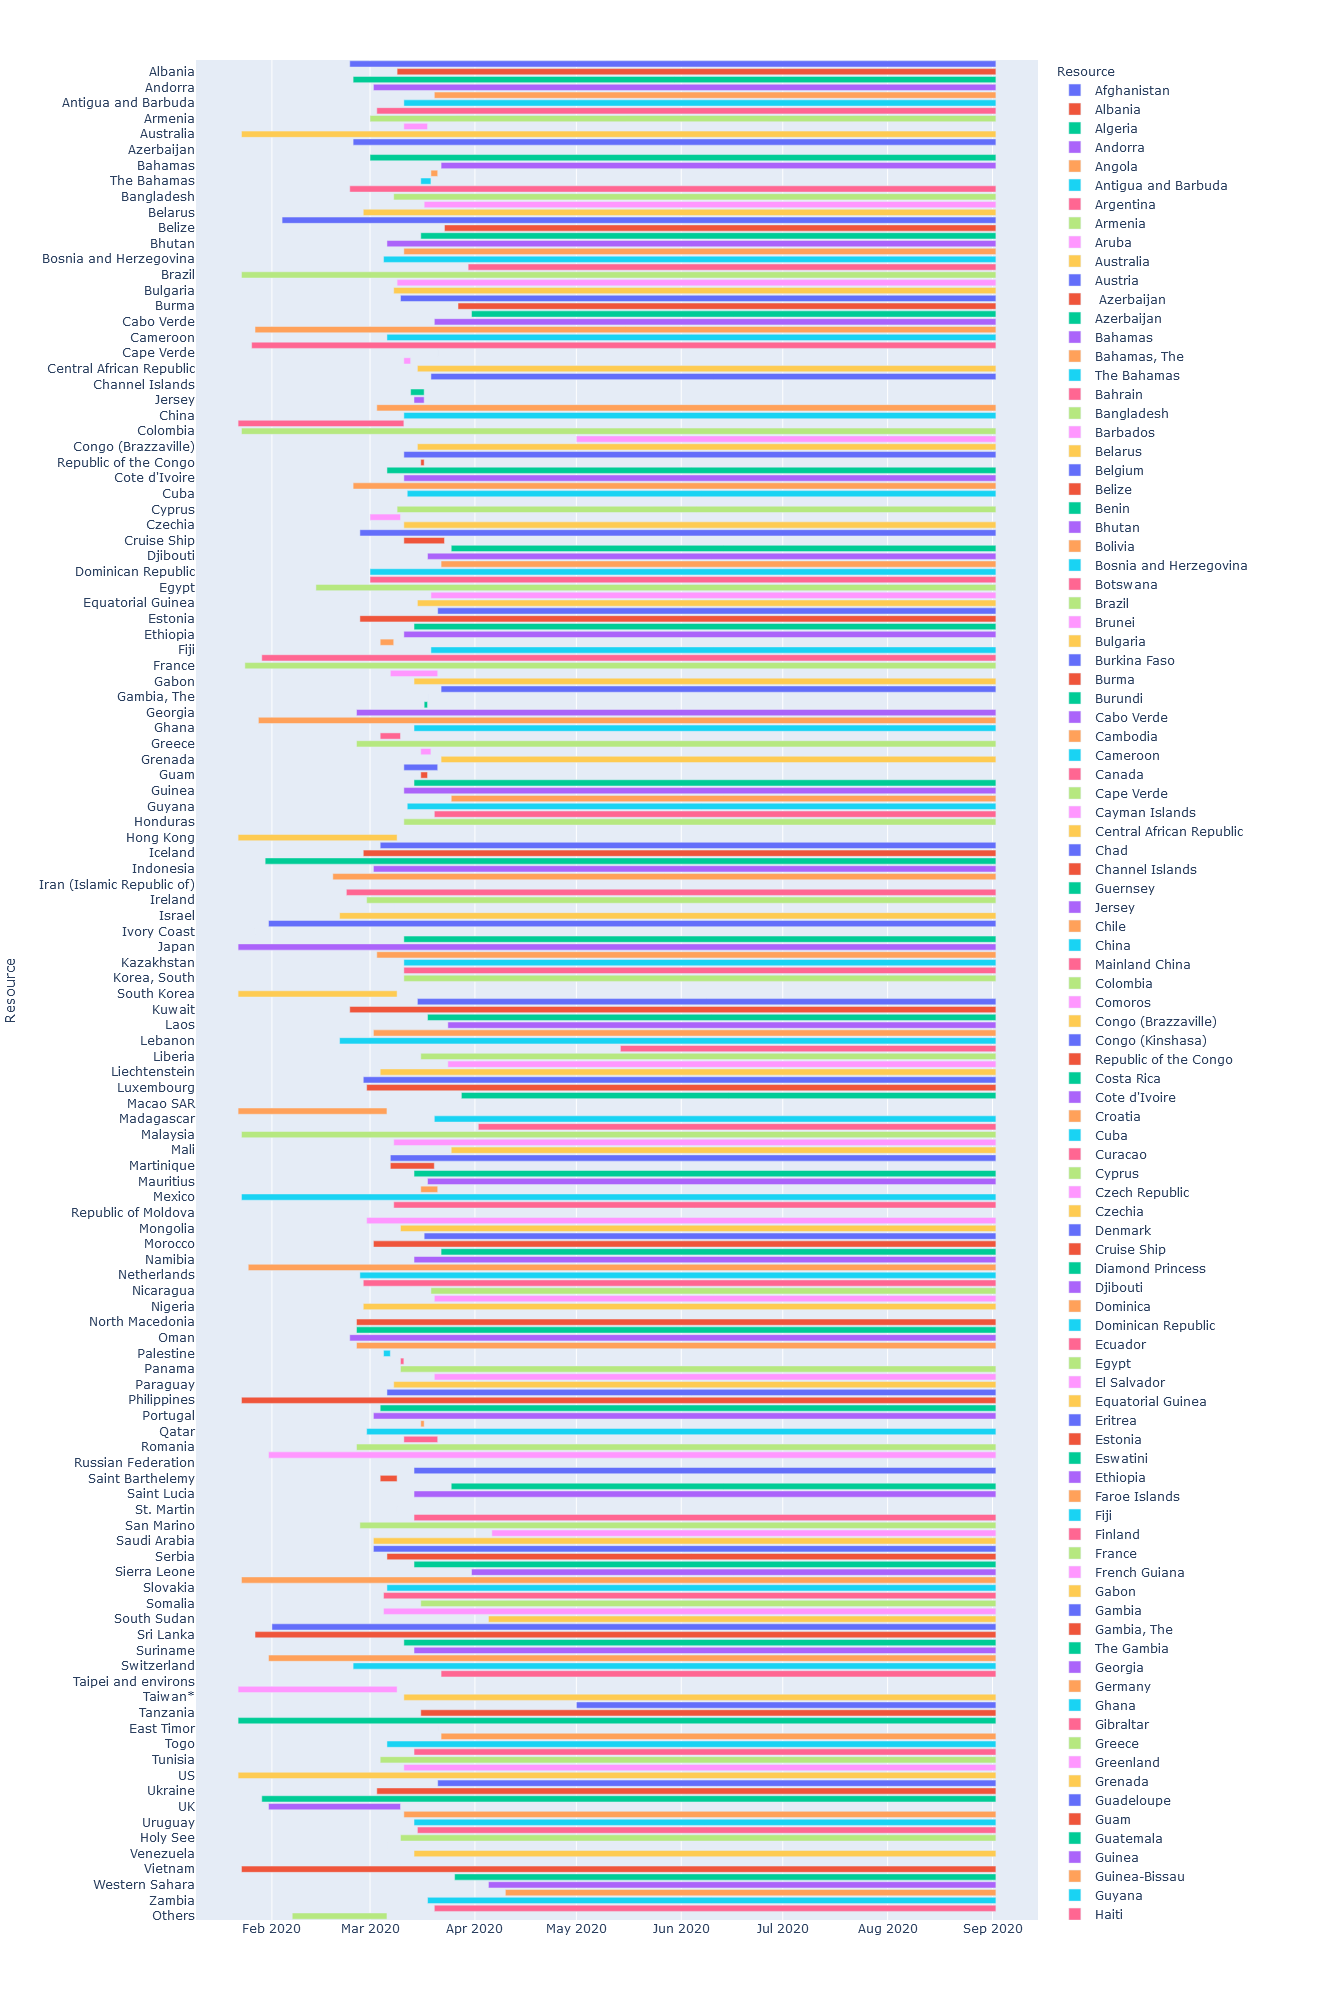

In [196]:
fig = px.timeline(pd.DataFrame(gantt_list), x_start="Start", x_end="Finish", y="Resource", color="Resource",
                  facet_row_spacing=0.5, width=1300, height=2000)

fig.show()